In [191]:
#!python -m pip install -U pyLDAvis

In [2]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
%pylab inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
import re
import string
from textblob import TextBlob
from better_profanity import profanity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer, wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from gensim.models import CoherenceModel
from gensim import matutils

import warnings
warnings.filterwarnings("ignore")



Populating the interactive namespace from numpy and matplotlib


/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning:

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.



In [3]:
#read in data

df= pd.read_csv('reddit_covid_vaccine_myths.csv')

In [4]:
df.head()

,post_id,post_title,post_score,post_timestamp,post_upvote_ratio,post_selftext,comment_id,comment_body,comment_timestamp,comment_ups,comment_downs
0,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h4le9is,"Impressive, if you just say the word ""debunked...",2021-07-09 14:24:06,8,0
1,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h4lgsqm,Here is another common myth:\n\n1. The COVID-1...,2021-07-09 14:44:05,4,0
2,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h4lgqh0,If you roll out a Novell vaccine during the pe...,2021-07-09 14:43:35,1,0
3,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h5axwli,An experiment with a fuck ton of money riding ...,2021-07-15 18:18:06,3,0
4,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h550f3m,Agreed. Let’s see how it is in the fall.,2021-07-14 10:17:02,1,0


In [50]:
df.shape

(2817, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   post_id            2817 non-null   object 
 1   post_title         2817 non-null   object 
 2   post_score         2817 non-null   int64  
 3   post_timestamp     2817 non-null   object 
 4   post_upvote_ratio  2817 non-null   float64
 5   post_selftext      2817 non-null   object 
 6   comment_id         2817 non-null   object 
 7   comment_body       2817 non-null   object 
 8   comment_timestamp  2817 non-null   object 
 9   comment_ups        2817 non-null   int64  
 10  comment_downs      2817 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 242.2+ KB


In [5]:
#change to datetime format

df['post_timestamp'] = pd.to_datetime(df['post_timestamp'])

df['comment_timestamp'] = pd.to_datetime(df['comment_timestamp'])


In [6]:
df.head()


,post_id,post_title,post_score,post_timestamp,post_upvote_ratio,post_selftext,comment_id,comment_body,comment_timestamp,comment_ups,comment_downs
0,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h4le9is,"Impressive, if you just say the word ""debunked...",2021-07-09 14:24:06,8,0
1,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h4lgsqm,Here is another common myth:\n\n1. The COVID-1...,2021-07-09 14:44:05,4,0
2,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h4lgqh0,If you roll out a Novell vaccine during the pe...,2021-07-09 14:43:35,1,0
3,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h5axwli,An experiment with a fuck ton of money riding ...,2021-07-15 18:18:06,3,0
4,ogslgq,COVID-19 Vaccine Myths and Conspiracy Theories,0,2021-07-09 10:12:50,0.36,"There have been many misconceptions, conspira...",h550f3m,Agreed. Let’s see how it is in the fall.,2021-07-14 10:17:02,1,0


In [7]:
#timestamps may already be sorted, but sorting in descending order just to be sure 


df.sort_values(by='post_timestamp',  inplace=True, ascending=False)


df.head(3)

,post_id,post_title,post_score,post_timestamp,post_upvote_ratio,post_selftext,comment_id,comment_body,comment_timestamp,comment_ups,comment_downs
12,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k1qxf,I really admire your tenacity and thank you fo...,2021-07-17 21:11:56,3,0
10,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k3wvt,Thank you,2021-07-17 21:30:38,4,0
11,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k27z2,Keep up the post. Don't let the anti-vax idiot...,2021-07-17 21:16:02,4,0


In [24]:
df.info()   #no nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2817 entries, 12 to 2770
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   post_id            2817 non-null   object        
 1   post_title         2817 non-null   object        
 2   post_score         2817 non-null   int64         
 3   post_timestamp     2817 non-null   datetime64[ns]
 4   post_upvote_ratio  2817 non-null   float64       
 5   post_selftext      2817 non-null   object        
 6   comment_id         2817 non-null   object        
 7   comment_body       2817 non-null   object        
 8   comment_timestamp  2817 non-null   datetime64[ns]
 9   comment_ups        2817 non-null   int64         
 10  comment_downs      2817 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memory usage: 264.1+ KB


## EDA

In [10]:
df['post_score'].unique()

array([   9,   24,  131,    5,   39,    0,    3,  498,   67, 5514,   17,
          8,   65,   20,   10,   15,    7,   61,   54,   14,    1,  365,
         21,   37,   94,  111,   13,  630,   26,   16,    4,   19,  302,
        125,  425,   32,    6,    2])

In [11]:
#What is the highest score about? 

print(df[df['post_score']==5514]['post_title'])  #most likely about subreddit rule changes, 
                                                    #not vaccine myths

584    On Vaccine-Related Posts Moving Forward
580    On Vaccine-Related Posts Moving Forward
581    On Vaccine-Related Posts Moving Forward
582    On Vaccine-Related Posts Moving Forward
583    On Vaccine-Related Posts Moving Forward
                        ...                   
416    On Vaccine-Related Posts Moving Forward
415    On Vaccine-Related Posts Moving Forward
414    On Vaccine-Related Posts Moving Forward
413    On Vaccine-Related Posts Moving Forward
423    On Vaccine-Related Posts Moving Forward
Name: post_title, Length: 486, dtype: object


In [12]:
#lets see comments too

print(df[df['post_score']==5514]['comment_body']) 

584                                            [removed]
580    How can you say that? I’m vaccinated and fully...
581    Yea like when did everyone start believing in ...
582           Yeah fr what is this person talking about?
583            You’re being downvoted but you’re correct
                             ...                        
416    I'm on the fence. On the one hand, I'm not one...
415    Twitter is still roasting him. A good one was ...
414    Also it's never a bad idea to sticky a thread ...
413    The only downside is that there won't be a red...
423    Agreed, he should be swapped with Darnold who ...
Name: comment_body, Length: 486, dtype: object


In [13]:
#Next highest score

print(df[df['post_score']==630]['post_title'])   #doesnt tell us much

1519    Coronavirus (COVID-19) Discussion Megathread - 9
1515    Coronavirus (COVID-19) Discussion Megathread - 9
1516    Coronavirus (COVID-19) Discussion Megathread - 9
1517    Coronavirus (COVID-19) Discussion Megathread - 9
1518    Coronavirus (COVID-19) Discussion Megathread - 9
                              ...                       
1350    Coronavirus (COVID-19) Discussion Megathread - 9
1352    Coronavirus (COVID-19) Discussion Megathread - 9
1353    Coronavirus (COVID-19) Discussion Megathread - 9
1354    Coronavirus (COVID-19) Discussion Megathread - 9
1351    Coronavirus (COVID-19) Discussion Megathread - 9
Name: post_title, Length: 496, dtype: object


In [14]:
#comments
print(df[df['post_score']==630]['comment_body'])    #seems like roughly positive sentiments about vaccine

1519                           Best of luck. Stay strong.
1515    It's a damn shame that both parties can't reac...
1516    People have become totally chilled out in Tela...
1517    It’ll take time, like the last peak. Even more so
1518    We(me + 3 family) were also positive. Took two...
                              ...                        
1350    Cases seem to be going down fast. It was hitti...
1352    Read this report online on the mixed vaccine t...
1353    \n####Bharat Biotech's U.S. partner Ocugen sub...
1354    Good morning. I hope this is the right place t...
1351    https://vaccine.crustdata.com/  \nFind the lis...
Name: comment_body, Length: 496, dtype: object


<AxesSubplot:xlabel='post_timestamp', ylabel='post_score'>

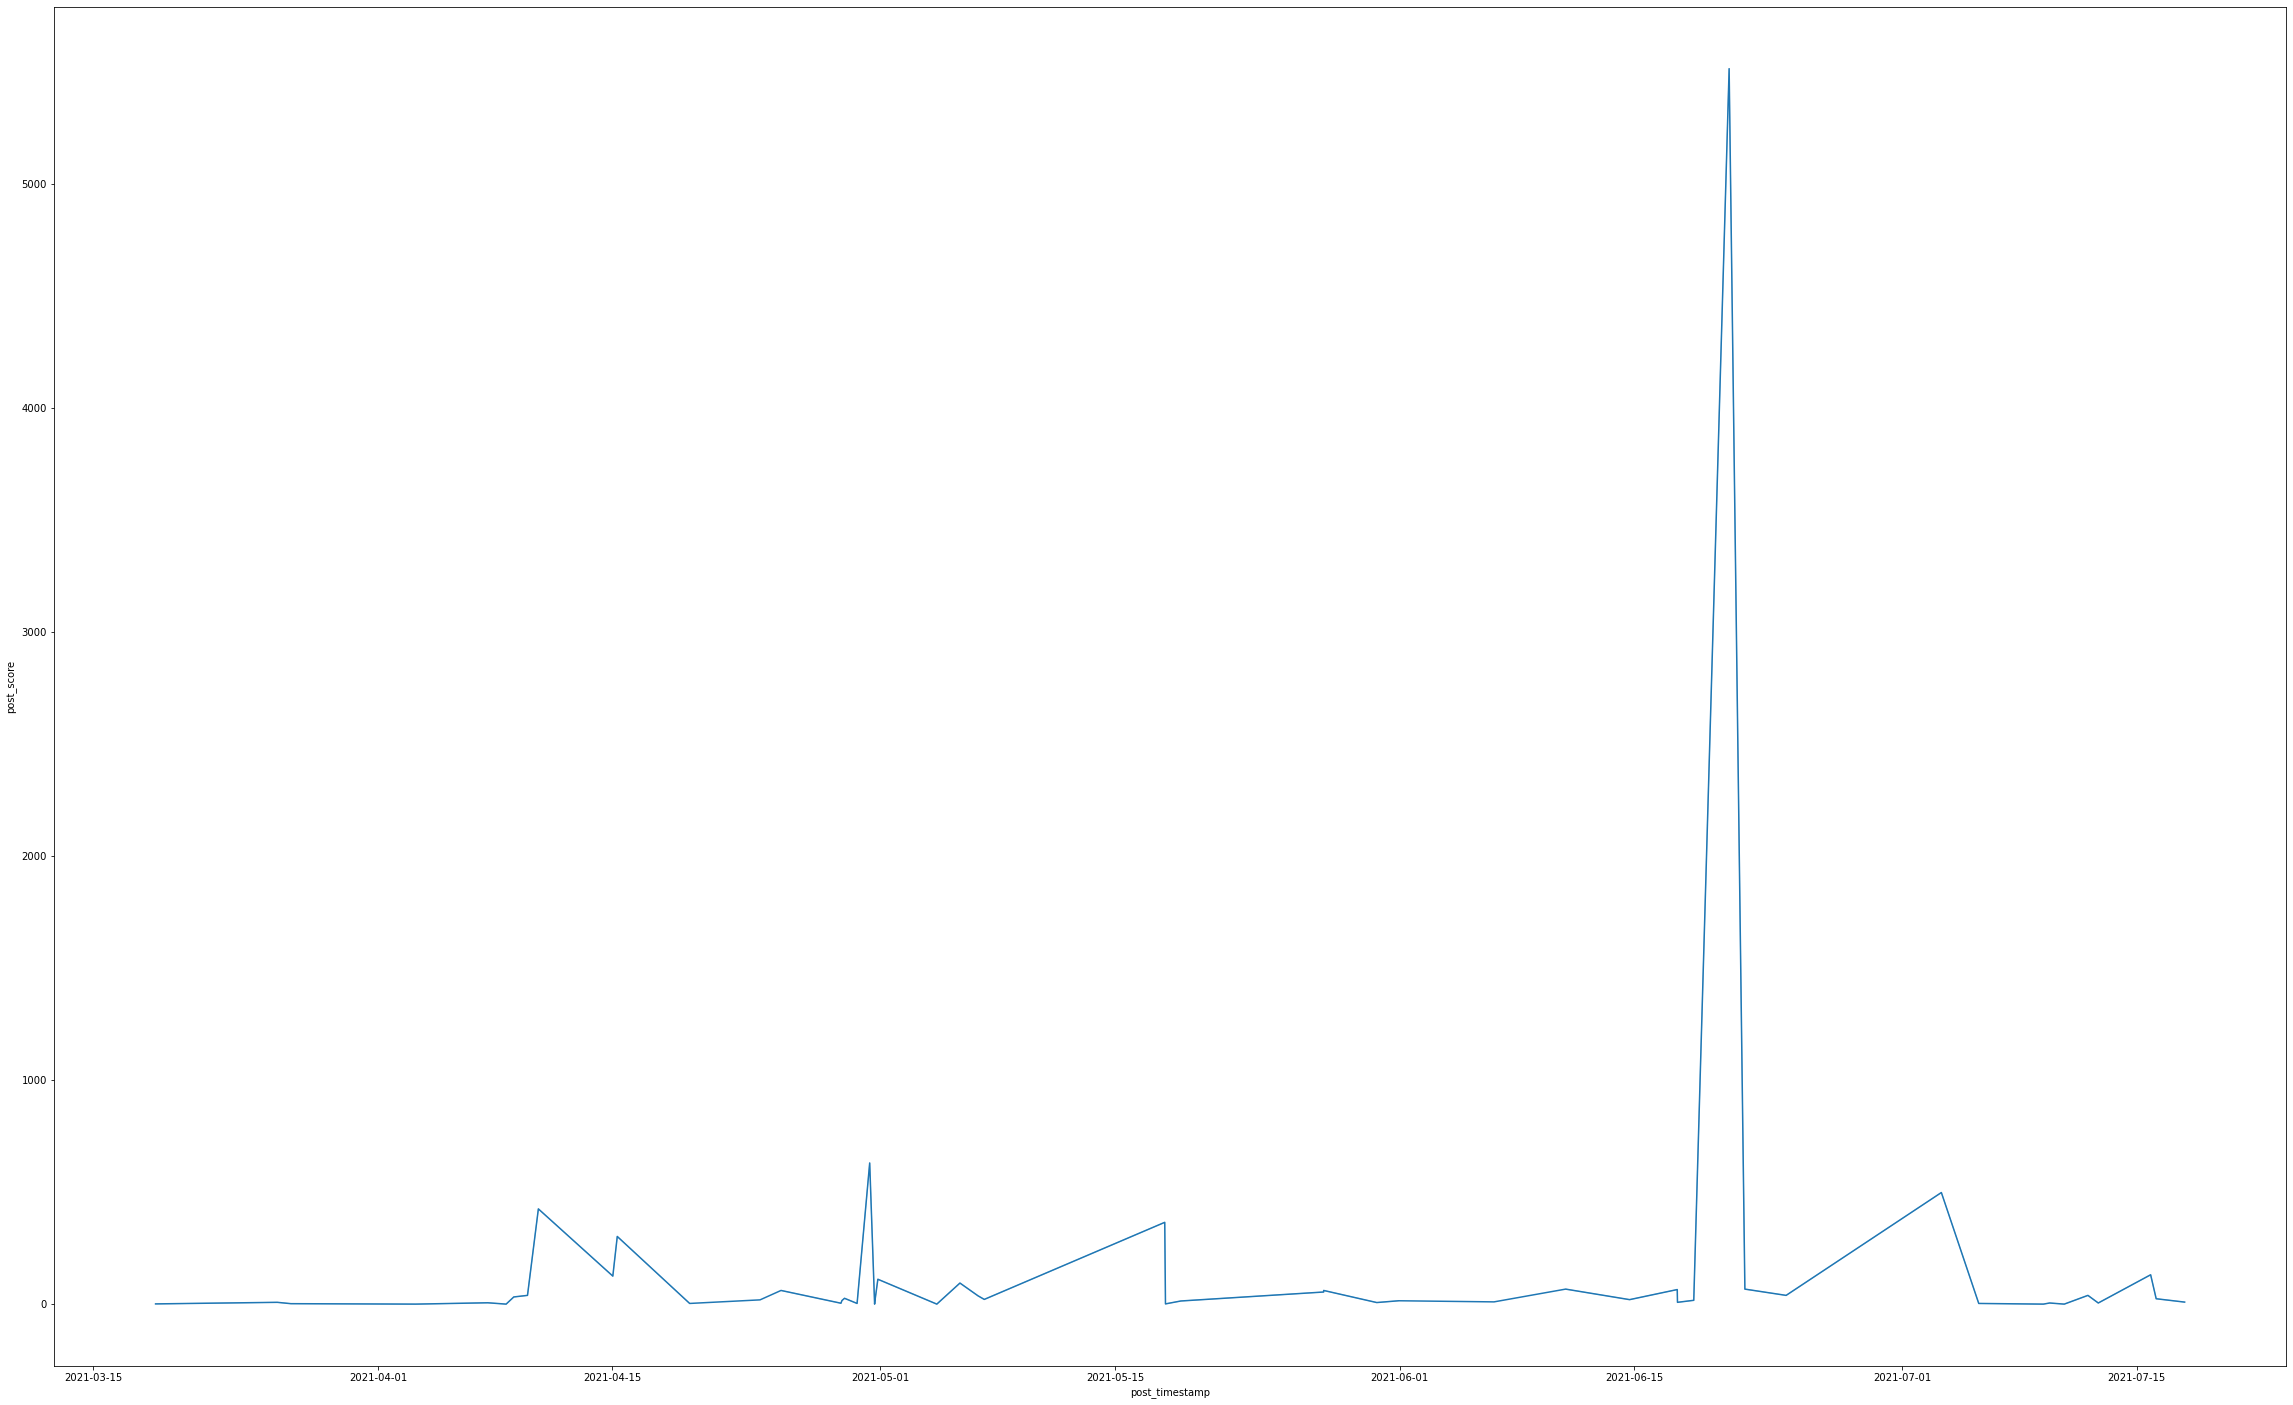

In [15]:
#post score over time

plt.figure(figsize=(40,25))
sns.lineplot(data=df, x="post_timestamp", y="post_score")

<AxesSubplot:xlabel='post_timestamp', ylabel='post_upvote_ratio'>

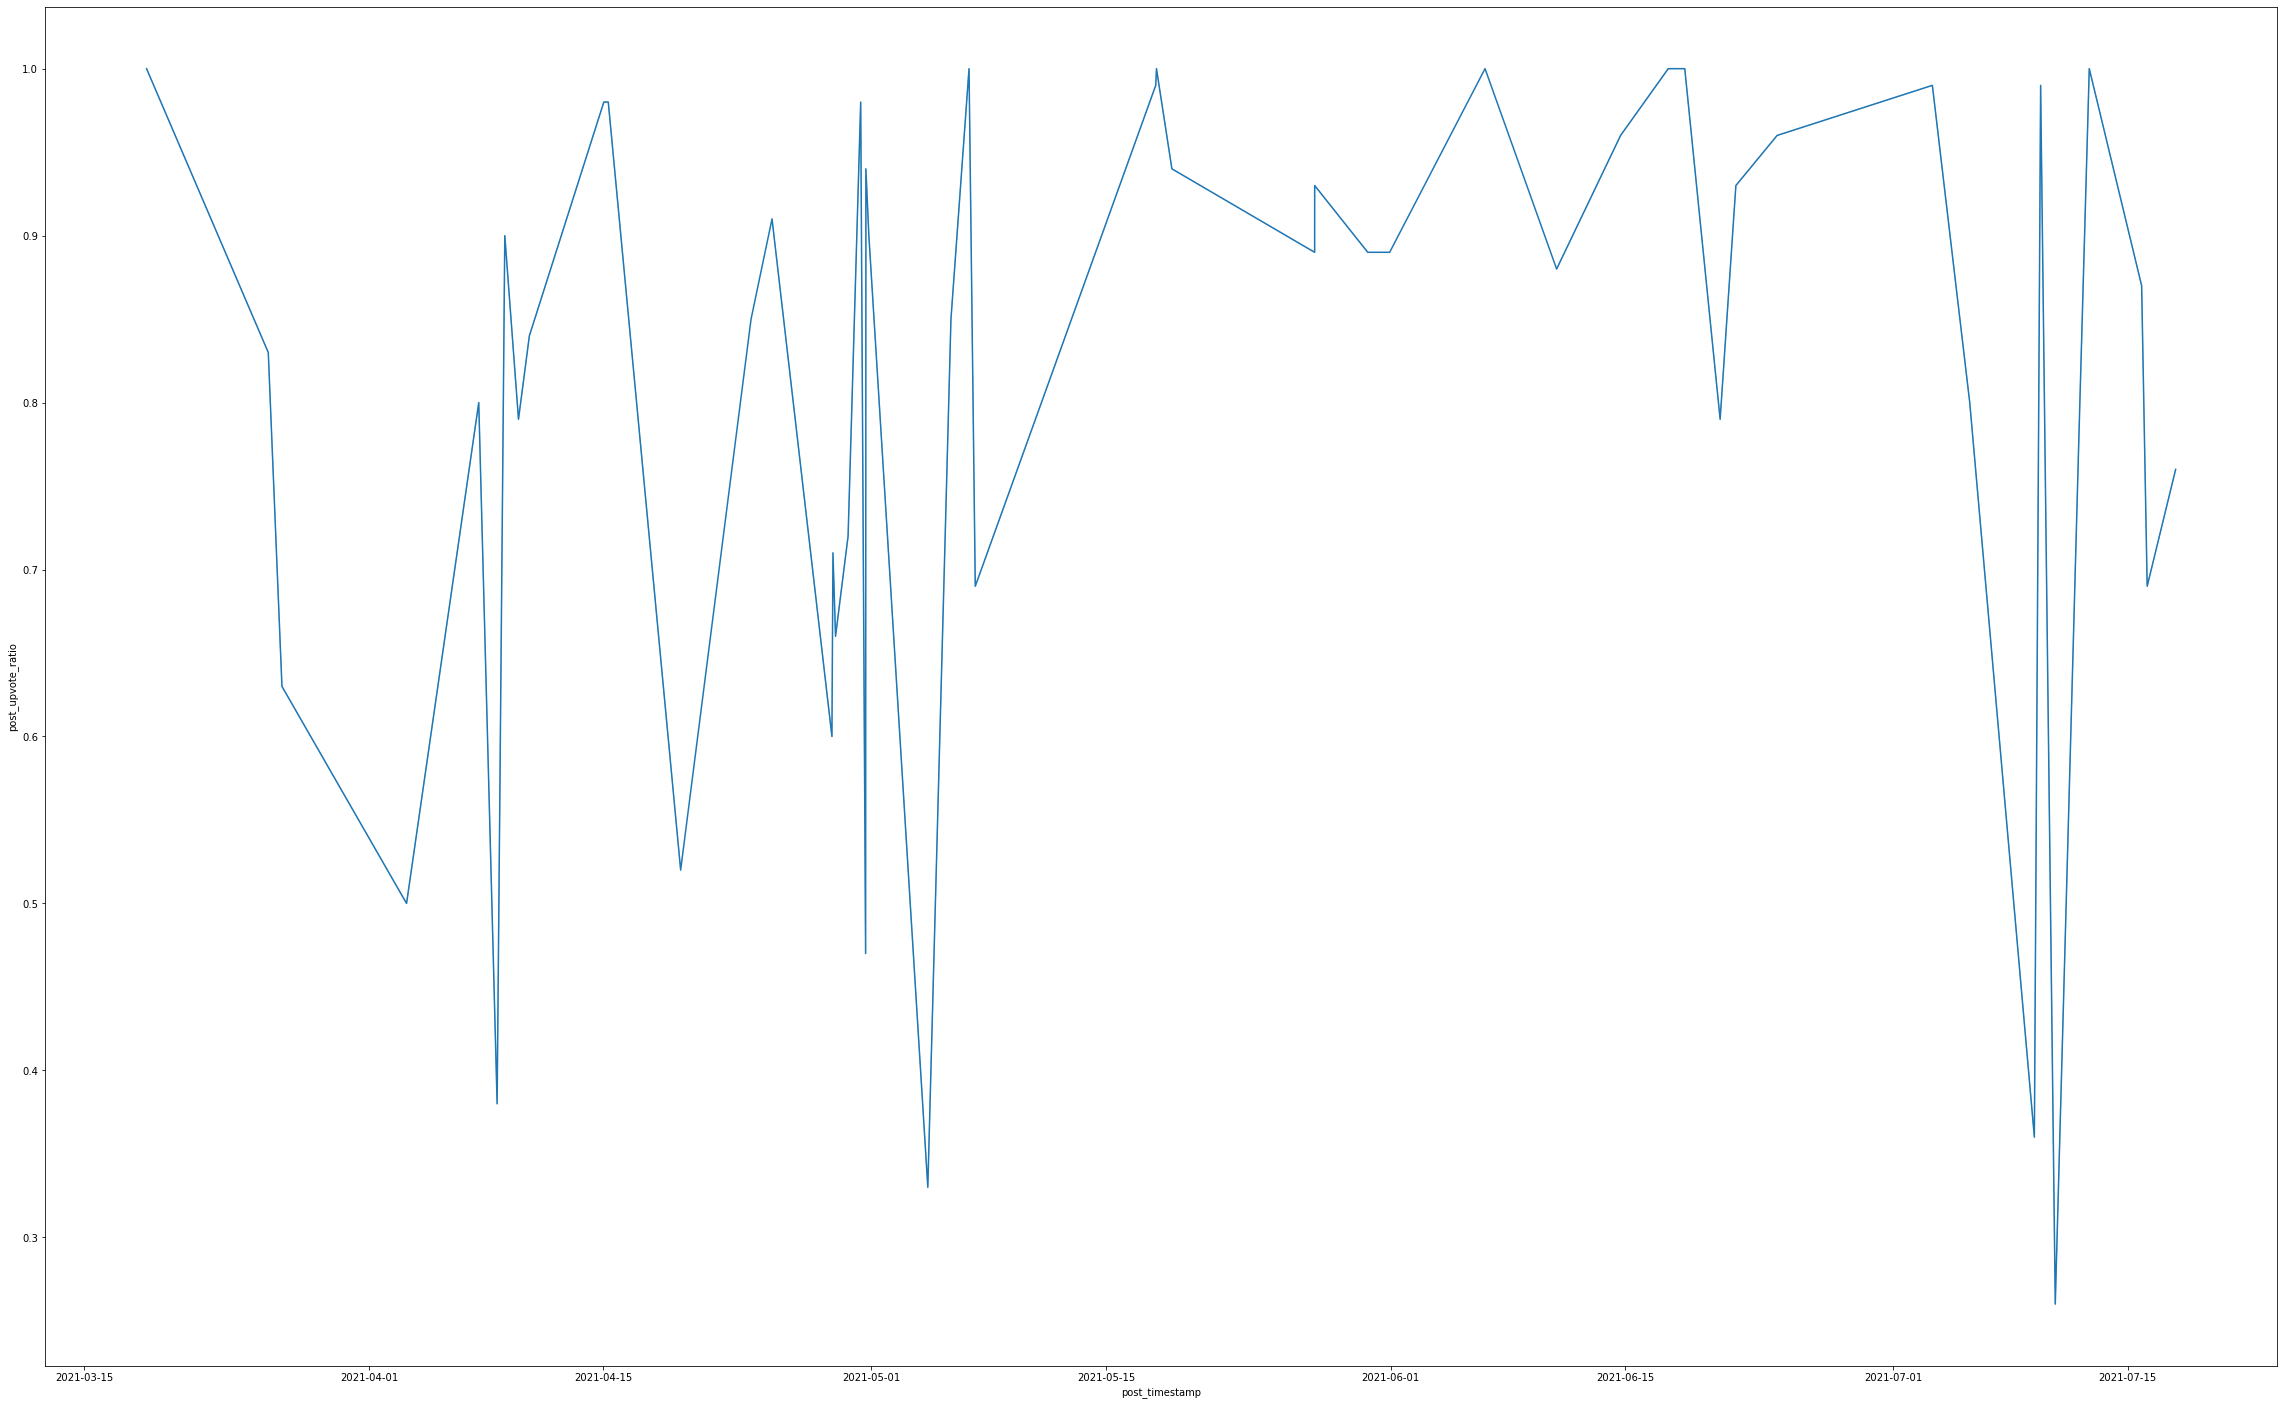

In [16]:
#post upvote ratio over time


plt.figure(figsize=(40,25))
sns.lineplot(data=df, x="post_timestamp", y="post_upvote_ratio")

In [8]:
# Upvote Ratio
fig = px.histogram(df, x="post_upvote_ratio")
fig.update_traces(marker_color="turquoise",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Post Upvote Ratio')
fig.show()

#here we can see that the upvote ratio is mostly high, 
#which means most posts have more upvotes than downvotes
#what this means for us is that whatever these posts are talking about 
#(whether they have antivaxx sentiments or not), people mostly agree with whats being said in the post
#note also that the dataset was scraped from r/all, not necessarily a specifically anti-vaxx subreddit


<AxesSubplot:xlabel='post_timestamp', ylabel='comment_downs'>

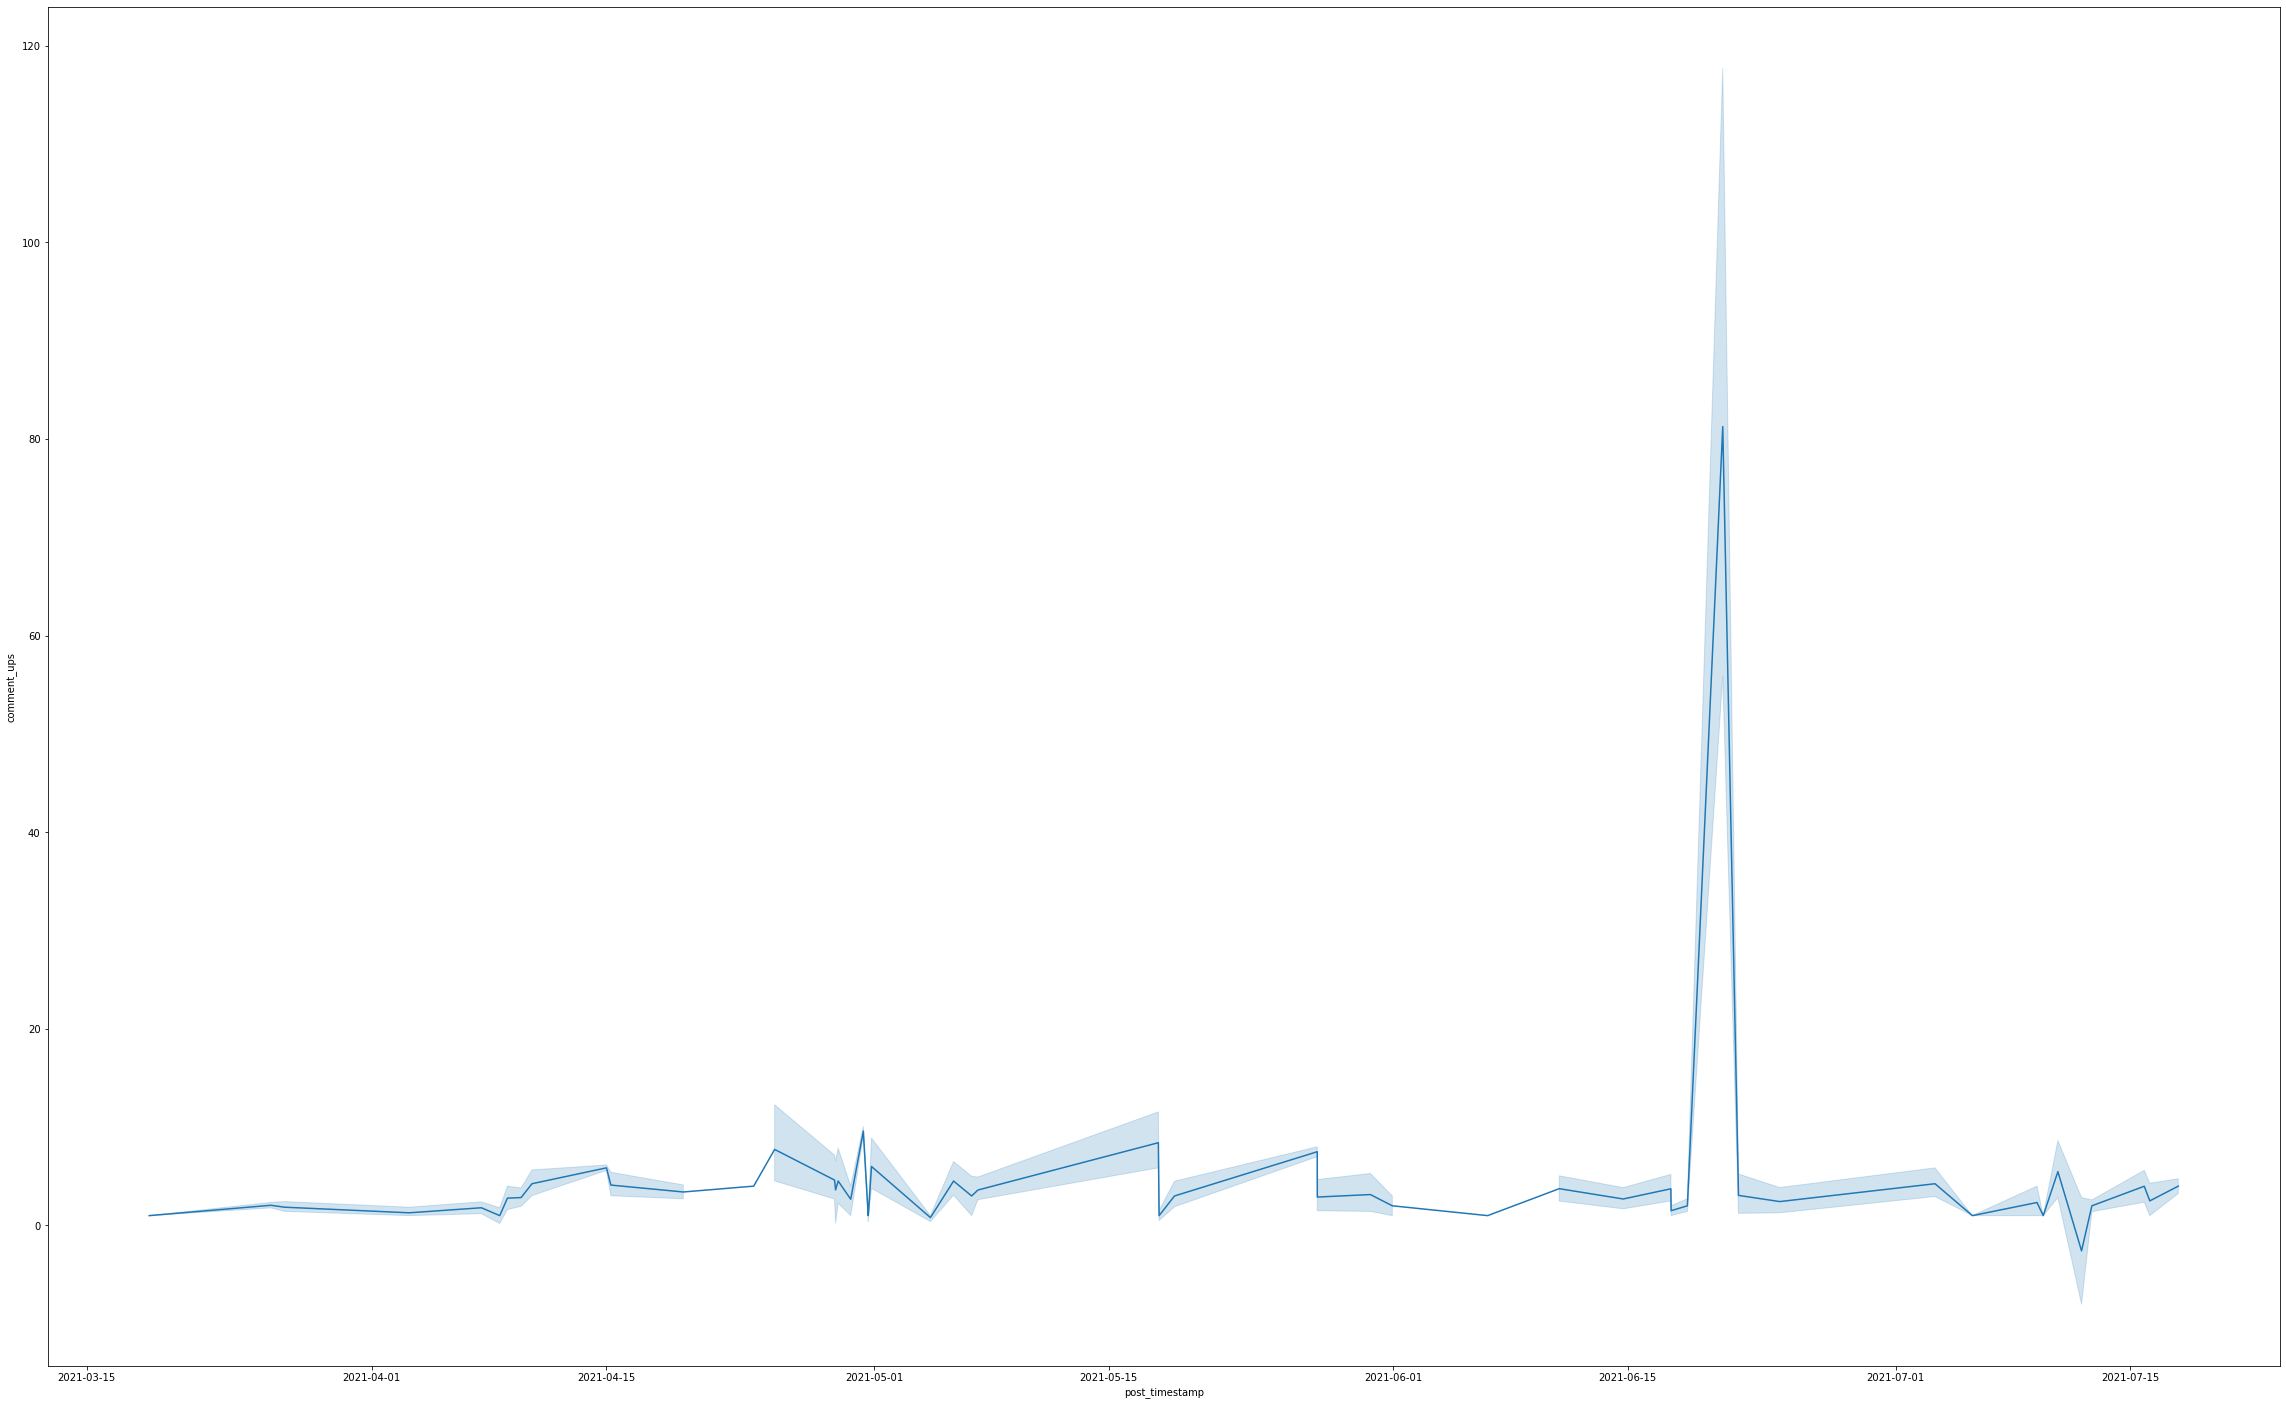

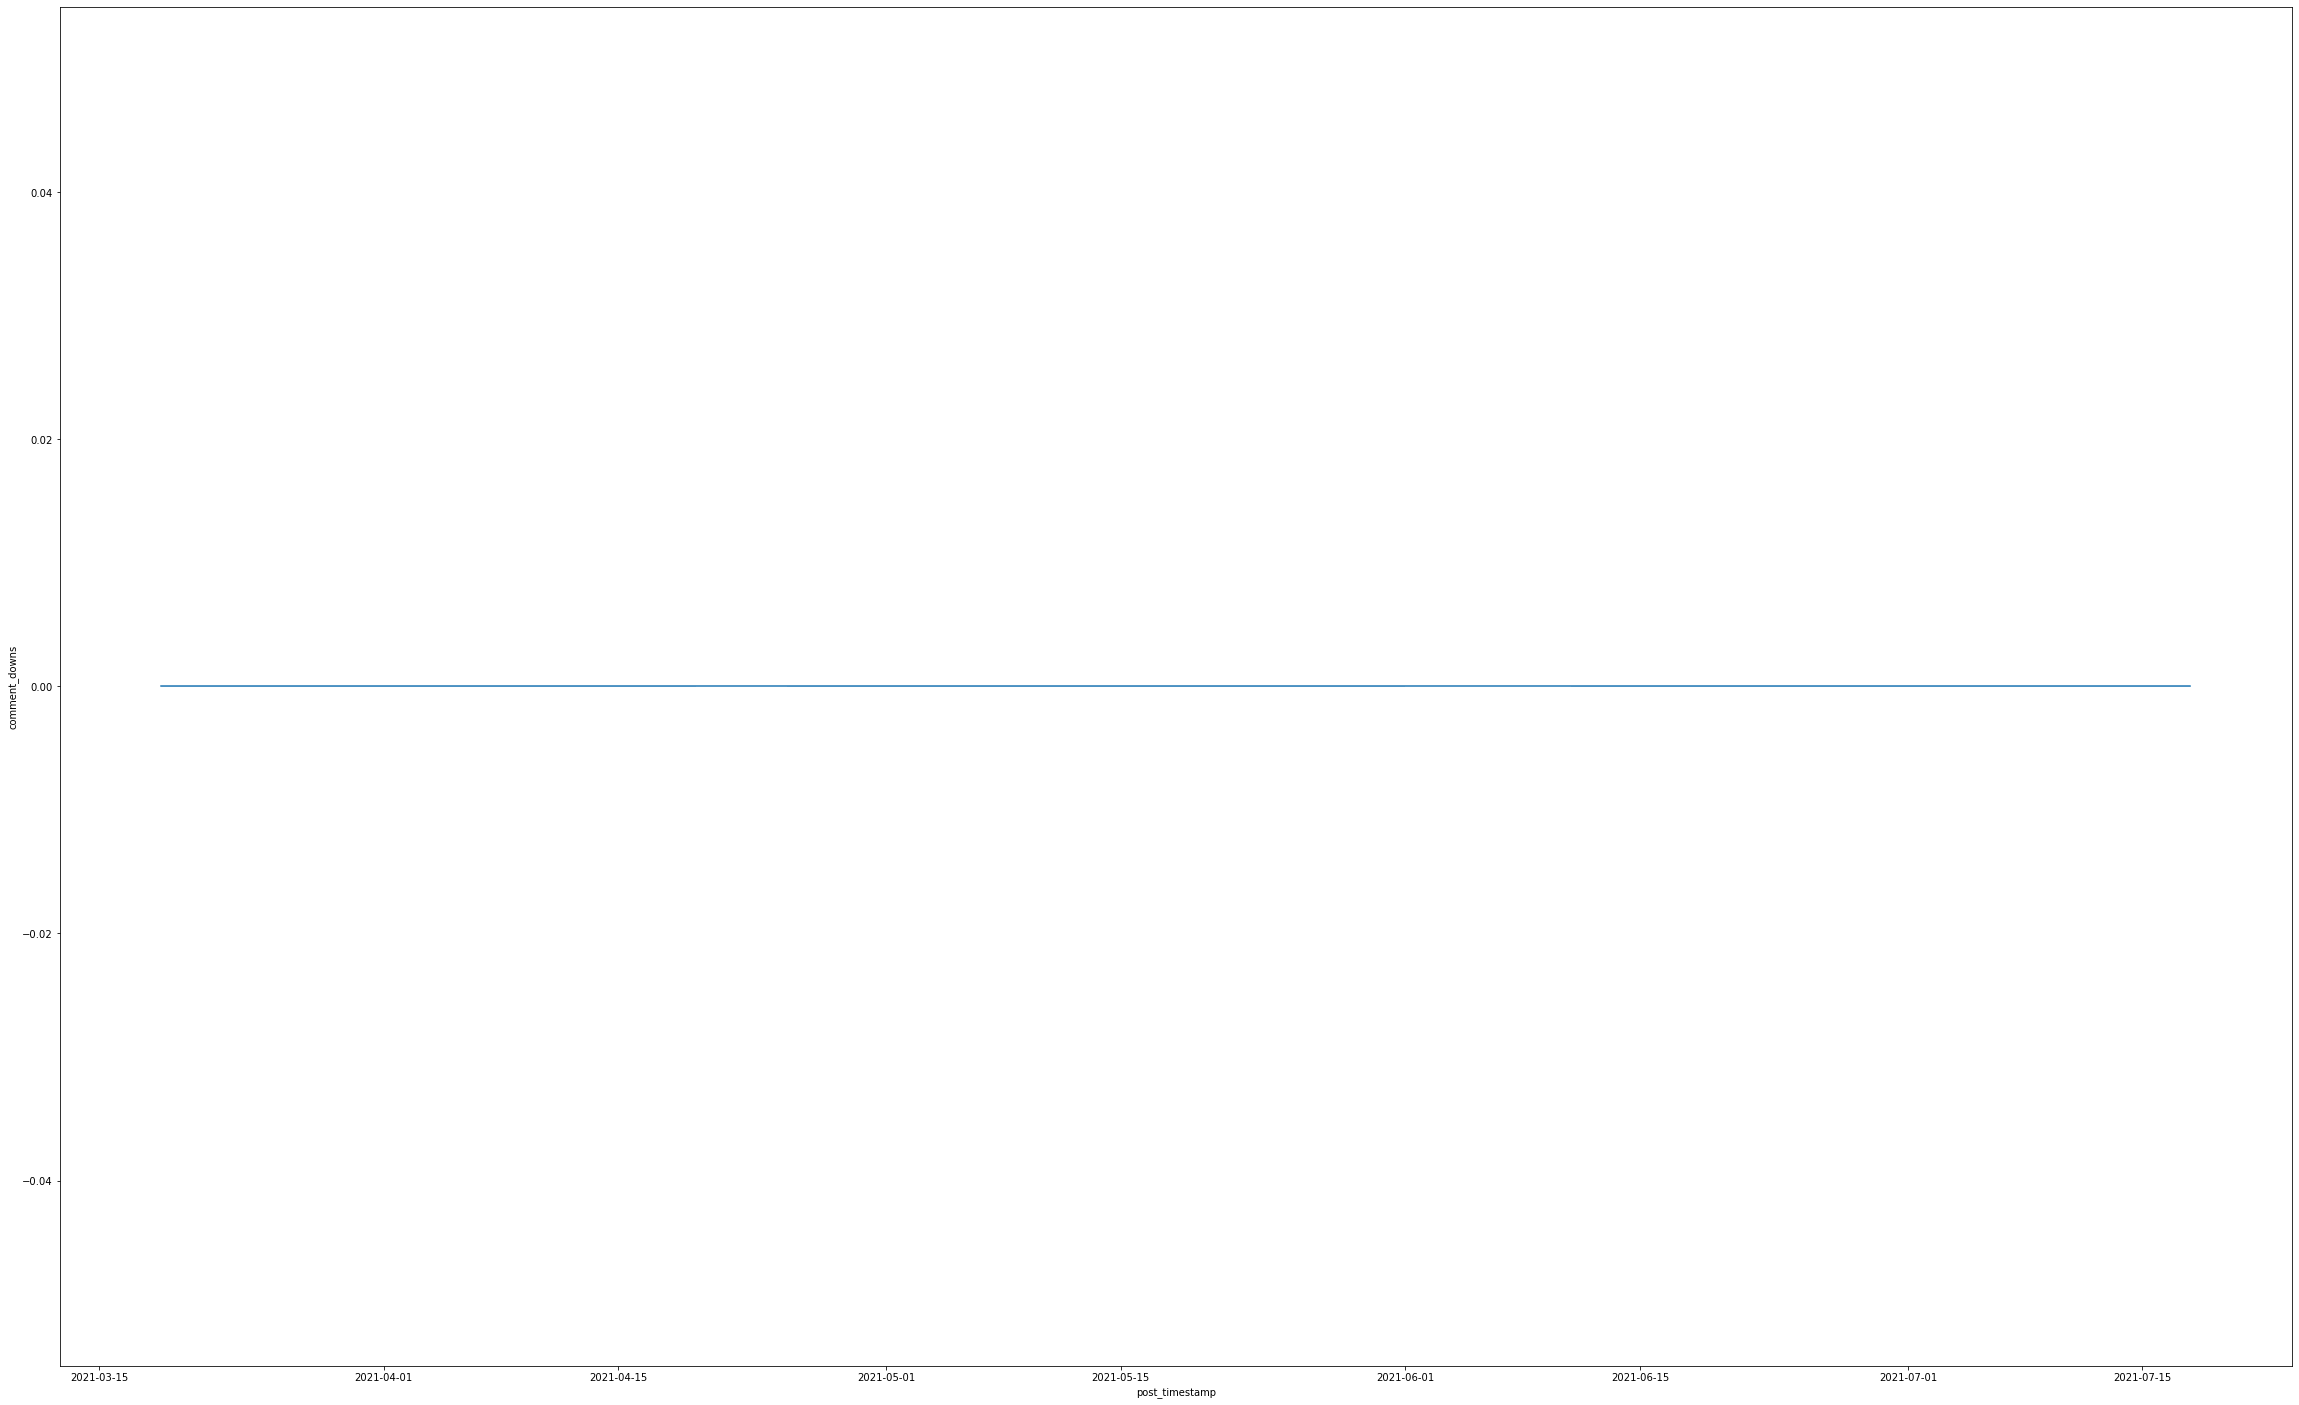

In [17]:
#post upvotes vs downvotes over time

plt.figure(figsize=(40,25))
sns.lineplot(x="post_timestamp", y="comment_ups", data=df)



plt.figure(figsize=(40,25))
sns.lineplot(x="post_timestamp", y="comment_downs", data=df)  #downvotes are not useful here as 
                                                                #theyre all zeros

In [9]:
#drop comment downs column 

df.drop(['comment_downs'], axis=1, inplace=True)

In [26]:
df.head()

,post_id,post_title,post_score,post_timestamp,post_upvote_ratio,post_selftext,comment_id,comment_body,comment_timestamp,comment_ups
12,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k1qxf,I really admire your tenacity and thank you fo...,2021-07-17 21:11:56,3
10,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k3wvt,Thank you,2021-07-17 21:30:38,4
11,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k27z2,Keep up the post. Don't let the anti-vax idiot...,2021-07-17 21:16:02,4
9,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k1xo5,I think the interesting thing here is the offi...,2021-07-17 21:13:33,5
105,ol8xoo,Update on Sjw-resistance: it is still trash. T...,24,2021-07-16 03:50:55,0.69,>[Biden's Angry Ramblings](https://www.deviant...,h5ger9p,Don’t apologize. That guy isn’t here posting i...,2021-07-16 23:10:01,1


In [10]:
#first make a copy of original df for nlp purposes

df2 = df.copy()
df2.head(2)

,post_id,post_title,post_score,post_timestamp,post_upvote_ratio,post_selftext,comment_id,comment_body,comment_timestamp,comment_ups
12,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k1qxf,I really admire your tenacity and thank you fo...,2021-07-17 21:11:56,3
10,omc9i2,Updated Covid numbers for McLennan County - co...,9,2021-07-17 20:38:33,0.76,Here are the latest numbers for McLennan Count...,h5k3wvt,Thank you,2021-07-17 21:30:38,4


In [11]:
df2=df2[['post_title', 'post_selftext', 'comment_body', 'comment_timestamp']]
df2.shape

(2817, 4)

In [19]:
#df3=df2[['post_selftext']]
#df3.head()
#df3.rename(columns = {'post_selftext':'corpus'}, inplace = True)
#df3.drop_duplicates(subset='corpus', keep="first", inplace=True)
#df3.shape
#df3.info()    #no nulls
#df3.head()

In [26]:
#df4=df2[['comment_body']]
#df4.rename(columns = {'comment_body':'corpus'}, inplace = True)
#df4.drop_duplicates(subset='corpus', keep="first", inplace=True)
#df4.shape
#df4.info()    #no nulls
#df4.head()

In [33]:
#df1=df2[['post_title']]
#df1.rename(columns = {'post_title':'corpus'}, inplace = True)
#df1.drop_duplicates(subset='corpus', keep="first", inplace=True)
#df1.shape
#df1.info()   #no nulls
#df1.head()

In [54]:
#creating a corpus by appending every textual column together into one column 



#df5=df1.append(df3)      #appending post_title to the bottom of post_selftext column   (5634 rows)
#df5.shape
#df5.head()
#df5.info()
#df6=df5.append(df4)                           #appending comment_body column to bottom of previous df
#df6.shape
#df6.info()
#df6.head() 
#df6.shape

#df6.sample(15)



,corpus
12,Updated Covid numbers for McLennan County - co...
105,Update on Sjw-resistance: it is still trash. T...
73,NIH director ‘most worried’ about Missouri’s C...
117,For those of you who want to get vaccinated bu...
119,County covid numbers are out and they're spiki...


In [55]:
#calling our df "corpus"
corpus = df6
corpus.sample(15)

,corpus
1178,"Hi Cartoondude. Listen, I don't want to overst..."
1175,Un résultat concret ne signifie pas nécessaire...
1475,Where can I get daily case numbers vs daily te...
1626,"Gennova is making an mRNA vaccine, hopefully w..."
1842,Risks of the vaccine are even lower than that.
194,Damn! This post is a fuckin A!
785,"What do you mean, ""go underground""? \n \nI l..."
2479,I'm so sorry for your loss. Hoping for a quick...
176,This is a masterpiece for posterity.
881,This post should be pinned


## Text Preprocessing 

In [56]:
#List of all english words in nltk
words = set(nltk.corpus.words.words())
len(words)

235892

In [57]:
def preprocessed_text(text):
    """
    This function makes text lowercase, remove punctuation, square brackets, and emojis
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[''""...]', '', text)
    text = re.sub('\n', '', text)
    #remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = profanity.censor(text)
    return text

In [58]:
# Corpus
cleaned_df = pd.DataFrame(corpus.corpus.apply(lambda x: preprocessed_text(x)))
cleaned_df.sample(10)

,corpus
1206,what to do to reduce exposure to covid and wha...
1975,youre the one they kept
1604,and the comments section is so reminiscent of ...
1519,new megathread for discussions about the seco...
766,i have been following the story of the ivermec...
2004,did indian government managed to have both the...
71,confirmation bias is a **** of a drug your as ...
560,same with josh allens all he said was that he ...
2216,president joe bidens chief medical adviser sa...
2495,comment to save for later reading


In [59]:
pd.set_option("max_colwidth", 250)
cleaned_df.sample(10)

,corpus
2114,incoming looking at the record high numbers from multiple states
1258,i absolutely am furious at the management and response of this government towards the pandemic however i need more inputs on what steps could be taken going forward exporting millions of vaccines holding election rallies kumbh mela all were suic...
1283,guys any of you or your relatives who are covid positive experiences chest pain after days please let me know asap
2810,iveno idea what you are talking about im not north american i dont know trump or biden or whoever and i dont follow politics because for me of politicians are vile pieces of **** and its all a circus you however seem to be so obsessed with them ...
228,i will be messaging you in months on to remind you of to send a pm to also be reminded and to reduce spamparent commenter can
2008,hellow i want to help india i am from france and i have an oxygen concentrator that nobody use in my house i want to send it in an hospital of new delhi to help you guysi am sure it will save at least one life you only need a little bit of water...
484,risk of getting either are lower with the vaccine than with getting covid and per your own link the cdc still recommends getting either also theres always the jj vaccine which doesnt seem to present those issues if someone is concerned sure talk ...
2054,this broke my heart
2680,well here is my thing im only on this sub because of the recent ufo stuff with the pentagon and now im here looking into other things yours seemed thought out and i like thought experiments the first thing i did was assume you were right thats wh...
1266,im not indian im just curious about the public opinion do indians blame anyone for the covid surge modi wealthy countries etc or is no one blamed and is it just seen as an unfortunate situation


In [60]:
cleaned_df.shape

(2834, 1)

In [61]:
#Removing unecessary words by selectng for default "english" stopwords, and adding words 
#that might occur a lot in our corpus

extended_stopwords = ['covid', 'corona', 'virus', 'vaccine']

stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(extended_stopwords)

### Document-Term Matrix using CountVectorizer 

In [62]:

cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['corpus'])

cv_dtm = pd.DataFrame(doc_word.toarray(), columns = cv.get_feature_names()).head(10)

In [63]:
cv_dtm

,aa,aaa,aaaah,aaah,aadhaar,aadhar,aadmi,aah,aaj,aam,...,zombiegal,zombies,zona,zone,zonein,zones,zoom,zoomies,zooms,zydus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
#Lots of sound effect words, lets lemmatize

### Lemmatization

In [64]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer

wnl = WordNetLemmatizer()
word_tokenizer = lambda x: word_tokenize(x)
lemmatize = lambda x: " ".join([wnl.lemmatize(w) for w in x])

In [65]:
cleaned_df['lemmatized'] = cleaned_df['corpus'].apply(word_tokenizer).apply(lemmatize)
cleaned_df

,corpus,lemmatized
12,updated covid numbers for mclennan county continuing to go up,updated covid number for mclennan county continuing to go up
105,update on sjwresistance it is still trash thank you,update on sjwresistance it is still trash thank you
73,nih director most worried about missouris spread compared to any state,nih director most worried about missouri spread compared to any state
117,for those of you who want to get vaccinated but have anticovid vaxx parents,for those of you who want to get vaccinated but have anticovid vaxx parent
119,county covid numbers are out and theyre spiking as expected,county covid number are out and theyre spiking a expected
...,...,...
2793,secrets in daniel still havent finished that one ben meaning to,secret in daniel still havent finished that one ben meaning to
2794,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro its heart breaking,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro it heart breaking
2816,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit its definitely different from the perspective of most of those here in canada or in the us though we dont have that excuse up here,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit it definitely different from the perspective of most of those here in canada or in the u though we dont have that excuse up here
2771,click if youd like to be notified when this post is solvedtype in the message subject if it hasnt already been filled in user is currently subscribed to this post,click if youd like to be notified when this post is solvedtype in the message subject if it hasnt already been filled in user is currently subscribed to this post


In [66]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['lemmatized'])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaa,aaaah,aaah,aadhaar,aadhar,aadmi,aah,aaj,aam,...,zoe,zoes,zombie,zombiegal,zona,zone,zonein,zoom,zoomies,zydus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
#lemmatized about 2000 words, although sound effects still very much present, 
#as well as words in languages other than English 

### Stemming:

In [67]:
stemmer = PorterStemmer()
word_tokenizer = lambda x: word_tokenize(x)
stemify = lambda x: " ".join([stemmer.stem(w) for w in x])


In [68]:
cleaned_df["stemmed"] = cleaned_df['corpus'].apply(word_tokenizer).apply(stemify)
cleaned_df

,corpus,lemmatized,stemmed
12,updated covid numbers for mclennan county continuing to go up,updated covid number for mclennan county continuing to go up,updat covid number for mclennan counti continu to go up
105,update on sjwresistance it is still trash thank you,update on sjwresistance it is still trash thank you,updat on sjwresist it is still trash thank you
73,nih director most worried about missouris spread compared to any state,nih director most worried about missouri spread compared to any state,nih director most worri about missouri spread compar to ani state
117,for those of you who want to get vaccinated but have anticovid vaxx parents,for those of you who want to get vaccinated but have anticovid vaxx parent,for those of you who want to get vaccin but have anticovid vaxx parent
119,county covid numbers are out and theyre spiking as expected,county covid number are out and theyre spiking a expected,counti covid number are out and theyr spike as expect
...,...,...,...
2793,secrets in daniel still havent finished that one ben meaning to,secret in daniel still havent finished that one ben meaning to,secret in daniel still havent finish that one ben mean to
2794,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro its heart breaking,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro it heart breaking,im glad you did i didnt want to say it either i want to fellowship with the bodi but when they start sound like fox news or ben shapiro it heart break
2816,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit its definitely different from the perspective of most of those here in canada or in the us though we dont have that excuse up here,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit it definitely different from the perspective of most of those here in canada or in the u though we dont have that excuse up here,that fair enough and honestli i can understand your perspect and sympath with you want to wait a bit it definit differ from the perspect of most of those here in canada or in the us though we dont have that excus up here
2771,click if youd like to be notified when this post is solvedtype in the message subject if it hasnt already been filled in user is currently subscribed to this post,click if youd like to be notified when this post is solvedtype in the message subject if it hasnt already been filled in user is currently subscribed to this post,click if youd like to be notifi when thi post is solvedtyp in the messag subject if it hasnt alreadi been fill in user is current subscrib to thi post


In [69]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['stemmed'])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaa,aaaah,aaah,aadhaar,aadhar,aadmi,aah,aaj,aam,...,zip,zoe,zombi,zombieg,zona,zone,zonein,zoom,zoomi,zydu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
#got rid of about 3000 words, but still has foreign languages present. Lets remove those:

### Deleting non-English words 

In [70]:
del_non_eng = lambda x: " ".join(w for w in nltk.word_tokenize(x) if w in words )
cleaned_df['nltk'] = cleaned_df['corpus'].apply(del_non_eng)

In [71]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['nltk'])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aam,abandon,abandoned,abduction,ability,abject,able,aboard,abolish,...,zebra,zee,zenith,zero,ziggurat,zinc,zip,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
#Still a few words that appear unstemmed, we can try spacy at this point

In [72]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [73]:
#example words to test
doc = nlp("abandon,abandoned, absence, absent, absentee, absolute, absolutely, absurd, absurdity, abundance, abundant, yep, yes, yeso, yo, youd, youve, zee")
" ".join([token.lemma_ for token in doc])


'abandon , abandon , absence , absent , absentee , absolute , absolutely , absurd , absurdity , abundance , abundant , yep , yes , yeso , yo , you d , you ve , zee'

In [74]:
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [76]:
cleaned_df['spacy'] = cleaned_df['corpus'].apply(spacy_lemmatize)
cleaned_df

,corpus,lemmatized,stemmed,nltk,spacy
12,updated covid numbers for mclennan county continuing to go up,updated covid number for mclennan county continuing to go up,updat covid number for mclennan counti continu to go up,covid for county to go up,update covid number for mclennan county continue to go up
105,update on sjwresistance it is still trash thank you,update on sjwresistance it is still trash thank you,updat on sjwresist it is still trash thank you,update on it is still trash thank you,update on sjwresistance it be still trash thank you
73,nih director most worried about missouris spread compared to any state,nih director most worried about missouri spread compared to any state,nih director most worri about missouri spread compar to ani state,director most worried about spread to any state,nih director most worried about missouris spread compare to any state
117,for those of you who want to get vaccinated but have anticovid vaxx parents,for those of you who want to get vaccinated but have anticovid vaxx parent,for those of you who want to get vaccin but have anticovid vaxx parent,for those of you who want to get but have,for those of you who want to get vaccinated but have anticovid vaxx parent
119,county covid numbers are out and theyre spiking as expected,county covid number are out and theyre spiking a expected,counti covid number are out and theyr spike as expect,county covid are out and theyre spiking as,county covid number be out and they re spike as expect
...,...,...,...,...,...
2793,secrets in daniel still havent finished that one ben meaning to,secret in daniel still havent finished that one ben meaning to,secret in daniel still havent finish that one ben mean to,in still havent finished that one ben meaning to,secret in daniel still have nt finish that one ben mean to
2794,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro its heart breaking,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro it heart breaking,im glad you did i didnt want to say it either i want to fellowship with the bodi but when they start sound like fox news or ben shapiro it heart break,glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben its heart breaking,I m glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben shapiro its heart break
2816,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit its definitely different from the perspective of most of those here in canada or in the us though we dont have that excuse up here,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit it definitely different from the perspective of most of those here in canada or in the u though we dont have that excuse up here,that fair enough and honestli i can understand your perspect and sympath with you want to wait a bit it definit differ from the perspect of most of those here in canada or in the us though we dont have that excus up here,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit its definitely different from the perspective of most of those here in canada or in the us though we dont have that excuse up here,that s fair enough and honestly I can understand your perspective and sympathize with you want to wait a bit its definitely different from the perspective of most of those here in canada or in the we though we do nt have that excuse up here
2771,click if youd like to be notified when this post is solvedtype in the message subject if it hasnt already been filled in user is currently subscribed to this post,click if youd like to be notified when this post is sol

In [77]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['spacy'])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaa,aaaah,aaah,aadhaar,aadhar,aadmi,aah,aaj,aam,...,zoe,zombie,zombiegal,zona,zone,zonein,zoom,zoomie,zydu,zydus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#not good, sound effects and foreign languages are back.
#Lets try a combination of nltk and spacy lemmatization

In [79]:
cleaned_df['clean'] = cleaned_df['nltk'].apply(spacy_lemmatize)
cleaned_df

,corpus,lemmatized,stemmed,nltk,spacy,clean
12,updated covid numbers for mclennan county continuing to go up,updated covid number for mclennan county continuing to go up,updat covid number for mclennan counti continu to go up,covid for county to go up,update covid number for mclennan county continue to go up,covid for county to go up
105,update on sjwresistance it is still trash thank you,update on sjwresistance it is still trash thank you,updat on sjwresist it is still trash thank you,update on it is still trash thank you,update on sjwresistance it be still trash thank you,update on it be still trash thank you
73,nih director most worried about missouris spread compared to any state,nih director most worried about missouri spread compared to any state,nih director most worri about missouri spread compar to ani state,director most worried about spread to any state,nih director most worried about missouris spread compare to any state,director most worried about spread to any state
117,for those of you who want to get vaccinated but have anticovid vaxx parents,for those of you who want to get vaccinated but have anticovid vaxx parent,for those of you who want to get vaccin but have anticovid vaxx parent,for those of you who want to get but have,for those of you who want to get vaccinated but have anticovid vaxx parent,for those of you who want to get but have
119,county covid numbers are out and theyre spiking as expected,county covid number are out and theyre spiking a expected,counti covid number are out and theyr spike as expect,county covid are out and theyre spiking as,county covid number be out and they re spike as expect,county covid be out and they re spike as
...,...,...,...,...,...,...
2793,secrets in daniel still havent finished that one ben meaning to,secret in daniel still havent finished that one ben meaning to,secret in daniel still havent finish that one ben mean to,in still havent finished that one ben meaning to,secret in daniel still have nt finish that one ben mean to,in still have nt finish that one ben mean to
2794,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro its heart breaking,im glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben shapiro it heart breaking,im glad you did i didnt want to say it either i want to fellowship with the bodi but when they start sound like fox news or ben shapiro it heart break,glad you did i didnt want to say it either i want to fellowship with the body but when they start sounding like fox news or ben its heart breaking,I m glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben shapiro its heart break,glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben its heart break
2816,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit its definitely different from the perspective of most of those here in canada or in the us though we dont have that excuse up here,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit it definitely different from the perspective of most of those here in canada or in the u though we dont have that excuse up here,that fair enough and honestli i can understand your perspect and sympath with you want to wait a bit it definit differ from the perspect of most of those here in canada or in the us though we dont have that excus up here,thats fair enough and honestly i can understand your perspective and sympathize with you wanting to wait a bit its definitely different from the perspective of most of those here in canada or in the us though we dont have that excuse up here,that s fair enough and honestly I can understand your perspective and symp

In [80]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['clean'])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aam,abandon,abduction,ability,abject,able,aboard,abolish,abomination,...,zebra,zee,zenith,zero,ziggurat,zinc,zip,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
#minimal difference from just nltk alone, but that's ok. 
#dropping redundant columns:

#cleaned_df = cleaned_df.drop(columns=['lemmatized','stemmed','spacy'])
#cleaned_df

In [84]:
cleaned_df.columns

Index(['corpus', 'nltk', 'clean'], dtype='object')

### Topic Modelling

In [85]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    This function will display the highest weighted words for our topics
    """
    for x, topic in enumerate(model.components_):
        if not topic_names or not topic_names[x]:
            print("\nTopic ", x)
        else:
            print("\nTopic: '", topic_names[x], "'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

### NMF

In [86]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat= pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [297]:
#doc_word

<2817x6018 sparse matrix of type '<class 'numpy.int64'>'
	with 44556 stored elements in Compressed Sparse Row format>

In [310]:
#clean_feat['abandon'].unique()

array([0, 1])

In [87]:
nmf_model1 = NMF(11)
doc_topic = nmf_model1.fit_transform(clean_feat)

display_topics(nmf_model1, cv.get_feature_names(), 10)


Topic  0
get, people, well, go, able, good, time, work, today, make

Topic  1
game, nt, make, sec, story, think, mobile, take, get, people

Topic  2
source, know, say, would, one, see, safety, might, people, find

Topic  3
trump, also, nt, post, make, policy, first, one, russia, even

Topic  4
feed, world, new, one, life, fiction, science, find, game, nt

Topic  5
ben, phone, might, time, one, know, new, press, contact, though

Topic  6
get, time, excavator, job, nt, like, work, want, make, order

Topic  7
trigonal, know, language, code, one, great, society, ie, mind, message

Topic  8
go, university, get, take, program, process, might, work, sop, people

Topic  9
nt, people, world, even, government, like, make, get, many, go

Topic  10
high, total, test, active, may, vaccination, dose, demand, new, rural


In [313]:
#type(doc_topic)

numpy.ndarray

In [211]:
#(nmf_model1.components_).shape

(11, 341)

In [89]:
#going to need to extend our stop list slightly to include nt, ie, get etc
#iteratively added other stopwords that I felt didn't offer much meaning


newstops = ['would','get','go','make','even','see','nt','sec','take','know', \
            'thing', 'since', 'per', 'ca', 'lot', 'hey', 'ago','say','one','see',\
            'might','also','first','new','ben','though','know','time','like','want',\
            'great','ie', 'able', 'well', 'little', 'many', 'think', 'two', 'try', \
            'become', 'next', 'today', 'really', 'bit', 'give', 'could', 'something',\
            'find', 'need', 'way', 'come', 'use', 'due', 'however', 'ask', 'may', 'good',\
            'thank', 'way', 'number', 'yes', 'right', 'look', 'big', 'keep', 'add', 'agree'\
           'convince', 'de', 'much', 'pretty', 'feel', 'ever', 'imagine'
           'please', 'anyone', 'someone', 'still', 'believe']
stopwords.extend(newstops)

In [90]:
cv = CountVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [91]:
clean_feat

,aa,aam,abandon,abduction,ability,abject,aboard,abolish,abomination,abort,...,zebra,zee,zenith,zero,ziggurat,zinc,zip,zombie,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
nmf_model2 = NMF(11)
doc_topic = nmf_model2.fit_transform(clean_feat)

display_topics(nmf_model2, cv.get_feature_names(), 10)


Topic  0
people, work, pandemic, year, start, news, capacity, day, state, talk

Topic  1
game, story, mobile, people, love, quality, high, long, technology, company

Topic  2
trump, post, policy, russia, send, evidence, prove, war, asylum, trade

Topic  3
feed, world, life, fiction, science, game, synopsis, beyond, adventure, high

Topic  4
source, safety, people, adverse, issue, study, reader, cover, effect, accord

Topic  5
trigonal, language, code, society, mind, message, key, world, people, variant

Topic  6
phone, contact, press, screen, wear, voice, music, long, trace, perhaps

Topic  7
excavator, job, work, order, operator, read, fill, doll, past, people

Topic  8
university, program, process, work, sop, people, application, research, score, set

Topic  9
high, total, test, active, vaccination, dose, demand, rural, datum, positive

Topic  10
world, government, people, money, public, rich, capitalism, enough, war, several


## Top Choice Model

In [97]:
#tuning countvectorizer parameters: max_dif, min_dif

cv = CountVectorizer(stop_words=stopwords, max_df = .9,min_df=2)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())


In [99]:
nmf_model3 = NMF(11)
doc_topic = nmf_model3.fit_transform(clean_feat)

display_topics(nmf_model3, cv.get_feature_names(), 10)


Topic  0
people, work, pandemic, year, start, news, capacity, day, state, talk

Topic  1
game, story, mobile, people, love, quality, high, long, technology, company

Topic  2
trump, post, policy, russia, send, evidence, prove, war, economy, trade

Topic  3
source, safety, people, adverse, issue, study, reader, cover, effect, accord

Topic  4
feed, world, life, fiction, science, game, synopsis, beyond, high, adventure

Topic  5
trigonal, language, code, society, mind, message, key, world, variant, people

Topic  6
excavator, job, work, order, operator, read, fill, doll, past, people

Topic  7
phone, contact, press, screen, wear, voice, music, long, trace, perhaps

Topic  8
university, program, process, work, sop, people, application, research, score, set

Topic  9
high, total, test, active, vaccination, dose, demand, rural, datum, positive

Topic  10
world, government, people, money, public, rich, capitalism, enough, several, holocaust


In [316]:
nmf_model1.

NMF(n_components=11)

Topics are becoming more coherent. My initial interpretation is that: 

 - Topic 0 could be about going back to work when the pandemic is over
 - Topic 1 positive sentiments about technology
 - Topic 2 political impact on Covid pandemic/ or vice versa
 - Topic 3 covid studies, new info on covid
 - Topic 4 seems to be a discussion on scientific evidence vs fiction/conspiracies?
 - The remainder of the topics are either redundant or incoherent

In [282]:
nmf_model3.components_

array([[0.00000000e+00, 5.07393805e-04, 2.21515524e-01, ...,
        2.21284710e-04, 1.97341162e-01, 6.03308419e-04],
       [0.00000000e+00, 0.00000000e+00, 5.38086743e-05, ...,
        0.00000000e+00, 0.00000000e+00, 3.70975877e-04],
       [0.00000000e+00, 8.42207198e-04, 1.00782548e-01, ...,
        0.00000000e+00, 0.00000000e+00, 8.19919098e-05],
       ...,
       [4.20455567e-05, 1.76448569e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.39128521e-03],
       [2.83089101e-03, 1.01043223e-03, 0.00000000e+00, ...,
        2.75092069e-04, 0.00000000e+00, 4.39795798e-04],
       [4.16688465e-05, 6.08257268e-04, 0.00000000e+00, ...,
        1.61081334e-03, 5.76994731e-01, 1.79013752e-04]])

In [101]:
###### replace clean_df w/ w/e dataframe contains the most 
###### recent/latest clean version of your corpus
###### replace the 'clean' column w/ w/e column it is that 
###### has the text you want to analyze

corpus_new_index = cleaned_df['clean'].reset_index()
del corpus_new_index['index']

corpus_new_index.head(10)

,clean
0,covid for county to go up
1,update on it be still trash thank you
2,director most worried about spread to any state
3,for those of you who want to get but have
4,county covid be out and they re spike as
5,this be why the world be face a covid apocalypse
6,to see it clearly
7,vaccine and conspiracy
8,I hereby insult you
9,the for graduate


In [102]:
cv_new = cv.transform(corpus_new_index['clean'])

In [104]:
# this allows you to apply a model to new text
# the output of this will be a numpy array of rows
# and columns; each row represents one of your 
# comments and each column represents the score against
# each topic
scores_array = nmf_model3.transform(cv_new)

In [106]:
scores_array.shape

(2834, 11)

In [107]:
# create temporary dataframe to store the feature values for each row of the corpus
tmp_scores_df = pd.DataFrame(scores_array)

In [108]:
tmp_scores_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.002272,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.009056,0.0
1,0.000929,0.0,0.0,0.0,0.0,0.0,0.0,0.010664,0.0,0.008669,0.0


In [109]:
# join this scores dataframe with the corpus dataframe
corpus_topic_scores = corpus_new_index.join(tmp_scores_df)

In [110]:
corpus_topic_scores

,clean,0,1,2,3,4,5,6,7,8,9,10
0,covid for county to go up,0.002272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009056,0.000000
1,update on it be still trash thank you,0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010664,0.000000,0.008669,0.000000
2,director most worried about spread to any state,0.008799,0.000000,0.000000,0.000071,0.000000,0.004105,0.000000,0.000000,0.000000,0.013085,0.002993
3,for those of you who want to get but have,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,county covid be out and they re spike as,0.002554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2829,in still have nt finish that one ben mean to,0.003636,0.002474,0.000572,0.003497,0.000000,0.004468,0.004682,0.000000,0.000000,0.000000,0.000000
2830,glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben its heart break,0.026484,0.000000,0.000000,0.000000,0.001043,0.002539,0.004797,0.003289,0.000000,0.000000,0.000000
2831,that s fair enough and honestly I can understand your perspective and sympathize with you want to wait a bit its definitely different from the perspective of most of those here in canada or in the we though we do nt have that excuse up here,0.002742,0.005023,0.000000,0.000000,0.000000,0.002701,0.020367,0.012615,0.006071,0.000000,0.013793
2832,click if you d like to be notify when this post be in the message subject if it already be fill in user be currently to this post,0.000000,0.000000,0.046548,0.000099,0.000000,0.006454,0.038940,0.000000,0.019180,0.000000,0.000000


In [112]:
corpus_topic_scores.columns = ['Corpus', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']
corpus_topic_scores.head(15)


,Corpus,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,covid for county to go up,0.002272,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009056,0.000000
1,update on it be still trash thank you,0.000929,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.010664,0.000000,0.008669,0.000000
2,director most worried about spread to any state,0.008799,0.000000,0.0,0.000071,0.000000,0.004105,0.000000,0.000000,0.000000,0.013085,0.002993
3,for those of you who want to get but have,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,county covid be out and they re spike as,0.002554,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008910,0.000000
5,this be why the world be face a covid apocalypse,0.000000,0.000000,0.0,0.000000,0.016327,0.000000,0.000000,0.000000,0.000000,0.000000,0.072557
6,to see it clearly,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.004955,0.000000,0.000000,0.000000,0.000000
7,vaccine and conspiracy,0.000000,0.000000,0.0,0.004885,0.000000,0.007841,0.000000,0.000000,0.000000,0.000000,0.000000
8,I hereby insult you,0.000000,0.000000,0.0,0.000000,0.000000,0.009305,0.000000,0.000000,0.000000,0.000000,0.000000
9,the for graduate,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.009888,0.000000,0.000000


In [113]:
corpus_topic_scores['most_relavant_topic'] = corpus_topic_scores[corpus_topic_scores.columns[1:]].apply(lambda x: x.argmax(), axis=1)


In [114]:
corpus_topic_scores

,Corpus,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,most_relavant_topic
0,covid for county to go up,0.002272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009056,0.000000,9
1,update on it be still trash thank you,0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010664,0.000000,0.008669,0.000000,7
2,director most worried about spread to any state,0.008799,0.000000,0.000000,0.000071,0.000000,0.004105,0.000000,0.000000,0.000000,0.013085,0.002993,9
3,for those of you who want to get but have,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,county covid be out and they re spike as,0.002554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008910,0.000000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,in still have nt finish that one ben mean to,0.003636,0.002474,0.000572,0.003497,0.000000,0.004468,0.004682,0.000000,0.000000,0.000000,0.000000,6
2830,glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben its heart break,0.026484,0.000000,0.000000,0.000000,0.001043,0.002539,0.004797,0.003289,0.000000,0.000000,0.000000,0
2831,that s fair enough and honestly I can understand your perspective and sympathize with you want to wait a bit its definitely different from the perspective of most of those here in canada or in the we though we do nt have that excuse up here,0.002742,0.005023,0.000000,0.000000,0.000000,0.002701,0.020367,0.012615,0.006071,0.000000,0.013793,6
2832,click if you d like to be notify when this post be in the message subject if it already be fill in user be currently to this post,0.000000,0.000000,0.046548,0.000099,0.000000,0.006454,0.038940,0.000000,0.019180,0.000000,0.000000,2


In [146]:
#n gram tuning 

cv = CountVectorizer(stop_words=stopwords,max_df = .8,min_df=2,ngram_range=(1, 2))
doc_word = cv.fit_transform(cleaned_df["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [147]:
nmf_model4 = NMF(11)
doc_topic = nmf_model4.fit_transform(clean_feat)

display_topics(nmf_model4, cv.get_feature_names(), 10)

/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).




Topic  0
people, work, pandemic, year, start, news, capacity, day, state, talk

Topic  1
game, story, mobile, people, love, quality, high, long, technology, company

Topic  2
source, source source, safety, people, adverse, issue, study, reader, cover, effect

Topic  3
trump, post, policy, russia, send, evidence, prove, war, economy, trade

Topic  4
feed, world, life, fiction, science, game, synopsis, beyond, high, adventure

Topic  5
excavator, job, work, order, operator, excavator operator, read, fill, doll, past

Topic  6
trigonal, language, code, society, mind, message, key, world, variant, people

Topic  7
phone, contact, press, screen, wear, voice, music, long, contact trace, trace

Topic  8
university, program, process, work, sop, people, application, research, score, set

Topic  9
high, total, test, active, dose, vaccination, demand, datum, rural, positive

Topic  10
world, government, people, money, public, rich, capitalism, enough, several, medium


In [123]:
#tuning n grams doesn't look like it helped much. We can try tfidf now 
#source comes up multiple times for some reason, why? 

In [165]:
cv = TfidfVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [166]:
nmf_model5 = NMF(11)
doc_topic = nmf_model5.fit_transform(clean_feat)

display_topics(nmf_model5, cv.get_feature_names(), 10)

/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).




Topic  0
bad, long, mean, point, world, effect, side, talk, information, sure

Topic  1
post, effort, excellent, save, pin, base, detailed, information, check, nothing

Topic  2
dose, second, single, month, shot, fever, immunity, efficacy, yesterday, protection

Topic  3
test, positive, fever, home, mild, friend, testing, negative, rapid, happen

Topic  4
work, awesome, put, super, watch, home, appreciate, excellent, job, negative

Topic  5
read, save, wo, write, effort, share, ton, hope, amazing, honestly

Topic  6
oxygen, help, hospital, doctor, home, bed, cylinder, situation, fever, experience

Topic  7
vaccination, news, drive, team, start, safe, wave, age, currently, infection

Topic  8
la, en, un, pour, cest, sur, se, ne, transmission, gen

Topic  9
government, central, state, million, crore, production, private, money, health, supply

Topic  10
low, high, testing, positivity, less, peak, case, rate, risk, normal


In [129]:
#Nothing significant is standing out. Surprisingly, NMF did a better 

In [152]:
#Tuning tfidf 

cv = TfidfVectorizer(stop_words=stopwords,min_df = 0.01, max_df = 0.95)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [153]:
nmf_model6 = NMF(11)
doc_topic = nmf_model6.fit_transform(clean_feat)

display_topics(nmf_model6, cv.get_feature_names(), 10)


Topic  0
people, information, agree, convince, call, world, person, care, wear, fully

Topic  1
day, fever, past, low, show, cough, last, normal, mild, case

Topic  2
post, effort, link, sub, list, information, write, relate, else, maybe

Topic  3
government, long, point, bad, mean, world, year, high, back, effect

Topic  4
work, job, put, home, kind, hospital, matter, hard, continue, medium

Topic  5
oxygen, hospital, doctor, home, care, high, level, save, available, situation

Topic  6
dose, second, single, month, dad, shot, hope, efficacy, fever, around

Topic  7
test, positive, testing, home, family, fever, mild, negative, week, dad

Topic  8
read, hope, write, never, save, effort, send, later, sub, comment

Topic  9
vaccination, population, news, transmission, fully, high, open, care, drive, infection

Topic  10
help, please, family, hope, share, send, link, doctor, wear, hospital


/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [154]:
#adding more stopwords

newerstops = ['agree', 'convinve', 'person', 'people', 'family', 'dad', 'call',\
             'fully', 'day', 'past', 'last', 'sub', 'relate', 'else', 'maybe'\
             'continue', 'medium', 'week', 'later', 'open', 'please', 'link']
stopwords.extend(newerstops)

In [159]:
cv = TfidfVectorizer(stop_words=stopwords,min_df = 0.01, max_df = 0.95, ngram_range=(1, 2))
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [160]:
nmf_model7 = NMF(11)
doc_topic = nmf_model7.fit_transform(clean_feat)

display_topics(nmf_model7, cv.get_feature_names(), 10)


Topic  0
long, bad, point, mean, high, world, effect, low, spread, around

Topic  1
post, effort, information, list, write, response, maybe, different, nothing, trump

Topic  2
dose, second, second dose, single, month, shot, fever, hope, efficacy, trial

Topic  3
test, positive, test positive, fever, testing, home, mild, negative, cough, normal

Topic  4
work, job, put, home, kind, hospital, hard, real, enough, matter

Topic  5
oxygen, hospital, doctor, home, care, save, fever, high, level, situation

Topic  6
read, hope, save, write, send, share, never, effort, wo, comment

Topic  7
vaccination, news, population, transmission, drive, high, infection, care, rate, health

Topic  8
help, hope, send, old, hospital, mean, situation, life, wear, available

Topic  9
government, central, state, million, production, money, private, us, hope, health

Topic  10
na, gon, gon na, tell, man, point, absolutely, lose, nice, transmission


/Users/aimanchughtai/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [ ]:
#despite adding stop words and tuning parameters, tfidf isnt doing so hot. I think nmf did better. 
#Moving on to LSA

### LSA 

In [179]:
#LSA with tfidf *No tuning

cv = TfidfVectorizer(stop_words=stopwords)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [180]:
model = TruncatedSVD(11)
doc_topic = model.fit_transform(clean_feat)

display_topics(model, cv.get_feature_names(), 10)


Topic  0
post, dose, test, work, vaccination, read, government, bad, positive, oxygen

Topic  1
post, read, effort, save, excellent, love, information, detailed, pin, base

Topic  2
dose, test, post, positive, second, fever, vaccination, la, single, month

Topic  3
test, positive, oxygen, fever, testing, home, post, friend, doctor, care

Topic  4
work, read, test, dose, positive, fever, awesome, save, second, home

Topic  5
read, oxygen, save, dose, write, hope, share, government, ton, send

Topic  6
oxygen, help, hospital, doctor, dose, work, home, bed, bad, fever

Topic  7
la, na, gon, en, un, cest, pour, sur, se, ne

Topic  8
vaccination, government, la, news, oxygen, low, testing, sure, en, work

Topic  9
vaccination, gon, na, news, bad, man, government, home, wave, tell

Topic  10
low, high, vaccination, risk, oxygen, testing, rate, positivity, gon, na


In [199]:
#too many similarities between topics. Stop words being ignored for some reason, and topics are incoherent

In [181]:
#LSA with tfidf, *tuning parameters

cv = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1), min_df = 0.01, max_df=.95)
doc_word = cv.fit_transform(cleaned_df['clean'])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [182]:
model2 = TruncatedSVD(11)
doc_topic = model2.fit_transform(clean_feat)

display_topics(model2, cv.get_feature_names(), 10)


Topic  0
post, work, test, dose, vaccination, government, read, help, long, bad

Topic  1
post, effort, write, list, trump, save, response, nice, set, cover

Topic  2
dose, test, positive, vaccination, fever, second, post, mild, single, shot

Topic  3
dose, vaccination, work, second, population, single, shot, government, long, month

Topic  4
work, test, dose, positive, fever, home, second, mild, job, month

Topic  5
oxygen, help, dose, hospital, hope, doctor, work, vaccination, second, home

Topic  6
read, dose, oxygen, hope, save, write, never, share, effort, everything

Topic  7
vaccination, oxygen, test, government, work, read, news, care, testing, positive

Topic  8
help, government, read, test, hope, vaccination, tell, positive, mean, love

Topic  9
government, dose, state, central, oxygen, news, month, home, let, positive

Topic  10
long, government, hope, high, bad, fever, low, already, back, side


Topics are becoming more coherent. My initial interpretation is that:
- Topic 0 could be about the governments plan to bring people in office after vaccines are distributed
- Topic 1 positive sentiments about Trump's efforts during the pandemic
- Topic 2 covid symptoms

The remainder of the topics are reiterating the first few. So far nmf still has most robust range of topics

#### At this point we've tried multiple iterations of topic modeling algorithms, and despite tuning parameters its seems the best iteration by far was with our NMF model using CountVectorizer and the following tuned parameters: max_df = .9,min_df=2

#### NMF model 3 will be our top choice topic modeling algorithm. (topic component scores are above)


In [115]:
#Reprinting NMF Model 3 data to view remainder of analysis in sequential order: 

In [116]:
nmf_model3 = NMF(11)
doc_topic = nmf_model3.fit_transform(clean_feat)

display_topics(nmf_model3, cv.get_feature_names(), 10)


Topic  0
people, work, pandemic, year, start, news, capacity, day, state, talk

Topic  1
game, story, mobile, people, love, quality, high, long, technology, company

Topic  2
trump, post, policy, russia, send, evidence, prove, war, economy, trade

Topic  3
source, safety, people, adverse, issue, study, reader, cover, effect, accord

Topic  4
feed, world, life, fiction, science, game, synopsis, beyond, high, adventure

Topic  5
trigonal, language, code, society, mind, message, key, world, variant, people

Topic  6
excavator, job, work, order, operator, read, fill, doll, past, people

Topic  7
phone, contact, press, screen, wear, voice, music, long, trace, perhaps

Topic  8
university, program, process, work, sop, people, application, research, score, set

Topic  9
high, total, test, active, vaccination, dose, demand, rural, datum, positive

Topic  10
world, government, people, money, public, rich, capitalism, enough, several, holocaust


# Final Topic Interpretations (Order by Coherency, Popularity, and Relavency for our Use Case)

 - Topic 9: need for vaccine in rural areas with high covid cases
 - Topic 0: going back to work, post pandemic
 - Topic 10: negative sentiments about government prioritization of economics over peoples lives
 - Topic 3: Covid vaccine adverse side effects 
 - Topic 6:  miscellaneous jobs 
 - Topic 7: tracing calls 
 - Topic 8: contribution of academia towards research 
 - Topic 2 Trump/Russia collusion, impact on economy and global affairs
 - Topic 4: discussion on scientific evidence vs fiction/conspiracies?
 - Topic 5: 5: miscellaneous, although only topic that talks about variants
 - Topic 1: general love for high quality tech
 
 
 
#### most_relavent_topic
- Topic 9:    598
- Topic 0:    515
- Topic 10:   419
- Topic 6:    255
- Topic 3:    218
- Topic 7:    204
- Topic 8:    194
- Topic 2:    169
- Topic 5:    110
- Topic 1:     87
- Topic 4:     65



In [158]:
corpus_topic_scores.sample(4)

,Corpus,most_relavent_topic,polarity,sentiment,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
762,I just whichever shot have the in it because my be trash got and now I just have these magnet,6,0.000000,Neutral,0.001374,0.000000,0.000000,0.0,0.000000,0.000000,0.004004,0.000000,0.000000,0.000000,0.001327
847,vaccination mutant just like super spreader,9,0.333333,Positive,0.000000,0.000000,0.000000,0.0,0.000000,0.004017,0.000000,0.000000,0.000000,0.026241,0.009465
198,as be my but my dad and even be if he get the delta variant it would probably he I would like to be able to see my on a regular basis as I be unable to do throughout and be not even talk about who ca nt even get the be not about a about your,5,0.000000,Neutral,0.003902,0.008807,0.000000,0.0,0.000000,0.023876,0.000000,0.000000,0.003965,0.010316,0.000000
2088,yes you can book for home sample collection on and they give report in day but I use it couple of ago,7,0.000000,Neutral,0.005443,0.002114,0.006208,0.0,0.001967,0.001491,0.000000,0.025022,0.000000,0.017299,0.000000


In [159]:
#rearrange columns

corpus_topic_scores = corpus_topic_scores[['Corpus', 'most_relavent_topic', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']]

corpus_topic_scores.head(2)

,Corpus,most_relavent_topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,covid for county to go up,9,0.002272,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.009056,0.0
1,update on it be still trash thank you,7,0.000929,0.0,0.0,0.0,0.0,0.0,0.0,0.010664,0.0,0.008669,0.0


## WordCloud: 

In [128]:
from statistics import mode
#find highest ranking topic:

mode(corpus_topic_scores['most_relavent_topic'])

9

In [177]:
# Importing libraries

import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline



In [162]:
text = " ".join(comment for comment in corpus_topic_scores.Corpus.astype(str))

In [163]:
print ("There are {} words in the combination of all cells in column Corpus.".format(len(text)))




There are 922898 words in the combination of all cells in column Corpus.


In [165]:
stpwrd= nltk.corpus.stopwords.words('english')
stopwords = set(stpwrd)
stopwords.update(['covid', 'corona', 'virus', 'vaccine',\
                      'would','get','go','make','even','see',\
                      'nt','sec','take','know', \
            'thing', 'since', 'per', 'ca', 'lot', 'hey', 'ago','say','one','see',\
            'might','also','first','new','ben','though','know','time','like','want',\
            'great','ie', 'able', 'well', 'little', 'many', 'think', 'two', 'try', \
            'become', 'next', 'today', 'really', 'bit', 'give', 'could', 'something',\
            'find', 'need', 'way', 'come', 'use', 'due', 'however', 'ask', 'may',\
                      'good','thank', 'way', 'number', 'yes', 'right', \
                      'look', 'big', 'keep', 'add', 'agree'\
           'convince', 'de', 'much', 'pretty', 'feel', 'ever', 'imagine'
           'please', 'anyone', 'someone', 'still', 'believe'])


In [181]:
mask = np.array(Image.open("reddit.png"))

In [182]:
# wordcloud function
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def show_wordcloud(text, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        mask = custom_mask,
        max_words = 100,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(text))
    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)
    plt.imshow(wordcloud)
    #fig.savefig("wordcloud.png")
    plt.show()
#print wordcloud
#show_wordcloud(vaxx_myths_df["clean_documents"])

In [ ]:
stopwords = set(STOPWORDS)

#Appearance-related
custom_mask = np.array(Image.open('batman.png')) 
wc = WordCloud(background_color = 'white',
               stopwords = stopwords,
               mask = custom_mask,
               contour_width = 3,
               contour_color = 'black')


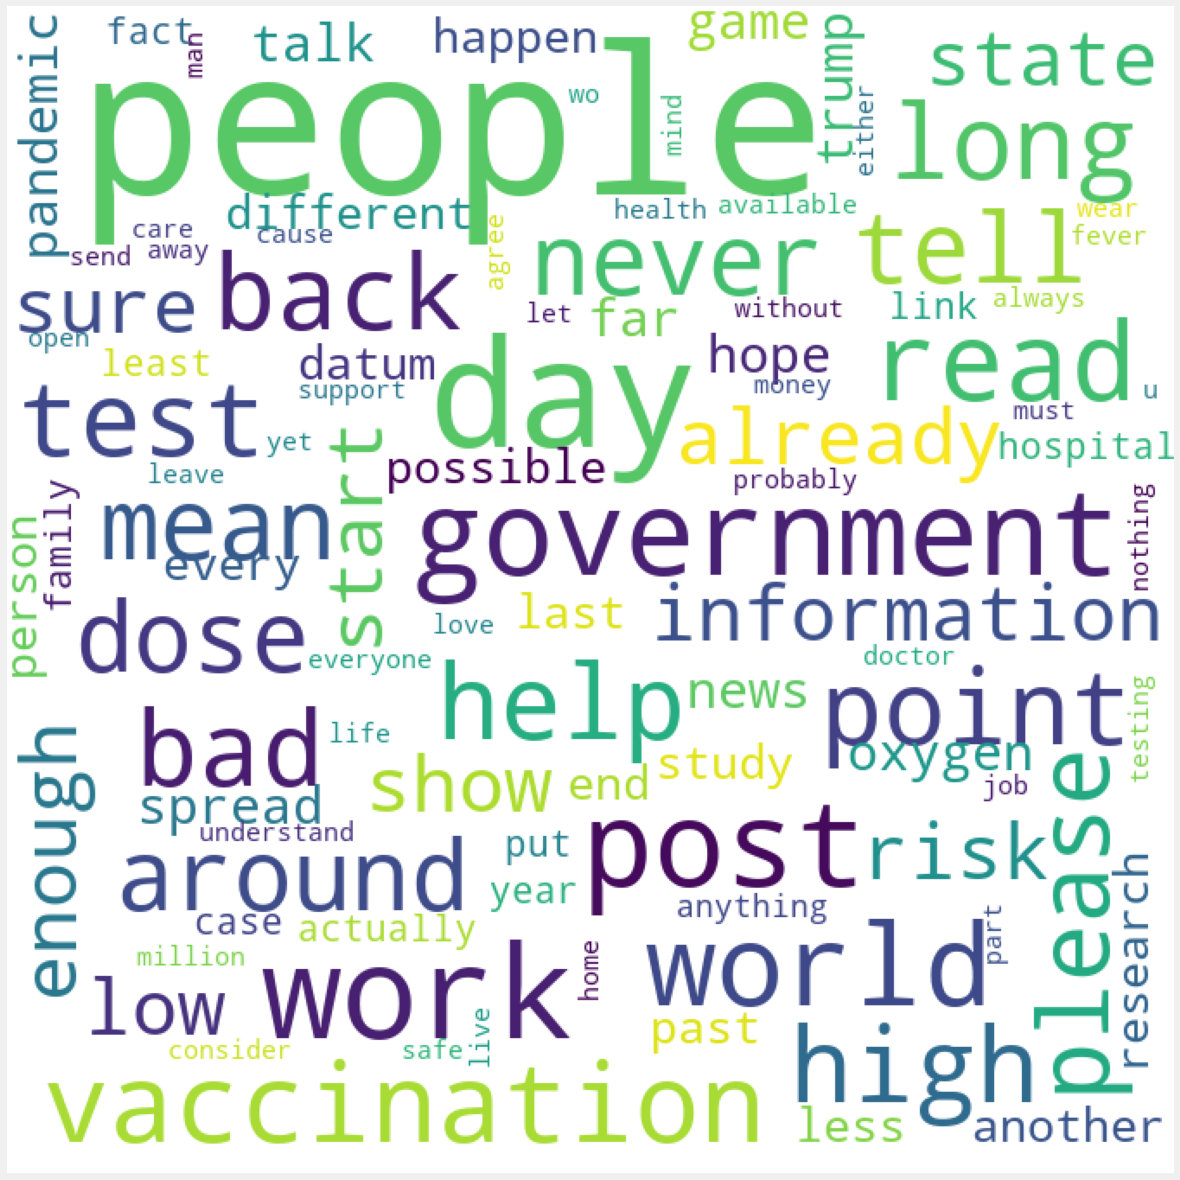

In [183]:
show_wordcloud(text)

## Sentiment Analysis:

In [189]:
corpus_topic_scores['polarity']= corpus_topic_scores['Corpus'].apply(lambda x: TextBlob(x).sentiment.polarity)



In [190]:
corpus_topic_scores.head()

,Corpus,most_relavent_topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,polarity
0,covid for county to go up,9,0.002272,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.009056,0.000000,0.0
1,update on it be still trash thank you,7,0.000929,0.0,0.0,0.000000,0.0,0.000000,0.0,0.010664,0.0,0.008669,0.000000,0.0
2,director most worried about spread to any state,9,0.008799,0.0,0.0,0.000071,0.0,0.004105,0.0,0.000000,0.0,0.013085,0.002993,0.5
3,for those of you who want to get but have,0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,county covid be out and they re spike as,9,0.002554,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.008910,0.000000,0.0


In [191]:
#rearrange columns once more

corpus_topic_scores = corpus_topic_scores[['Corpus', 'most_relavent_topic', 'polarity', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']]

corpus_topic_scores

,Corpus,most_relavent_topic,polarity,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,covid for county to go up,9,0.000000,0.002272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009056,0.000000
1,update on it be still trash thank you,7,0.000000,0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010664,0.000000,0.008669,0.000000
2,director most worried about spread to any state,9,0.500000,0.008799,0.000000,0.000000,0.000071,0.000000,0.004105,0.000000,0.000000,0.000000,0.013085,0.002993
3,for those of you who want to get but have,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,county covid be out and they re spike as,9,0.000000,0.002554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,in still have nt finish that one ben mean to,6,-0.312500,0.003636,0.002474,0.000572,0.003497,0.000000,0.004468,0.004682,0.000000,0.000000,0.000000,0.000000
2830,glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben its heart break,0,0.450000,0.026484,0.000000,0.000000,0.000000,0.001043,0.002539,0.004797,0.003289,0.000000,0.000000,0.000000
2831,that s fair enough and honestly I can understand your perspective and sympathize with you want to wait a bit its definitely different from the perspective of most of those here in canada or in the we though we do nt have that excuse up here,6,0.291667,0.002742,0.005023,0.000000,0.000000,0.000000,0.002701,0.020367,0.012615,0.006071,0.000000,0.013793
2832,click if you d like to be notify when this post be in the message subject if it already be fill in user be currently to this post,2,-0.083333,0.000000,0.000000,0.046548,0.000099,0.000000,0.006454,0.038940,0.000000,0.019180,0.000000,0.000000


In [192]:
corpus_topic_scores['polarity'].value_counts()

 0.000000    813
 0.200000     59
 0.500000     53
 0.250000     46
 0.100000     37
            ... 
-0.082500      1
 0.069444      1
 0.008333      1
 0.282000      1
 0.291667      1
Name: polarity, Length: 1152, dtype: int64

In [131]:
# Polarity Distribution
fig = px.histogram(corpus_topic_scores, x="polarity")
fig.update_traces(marker_color="Purple",marker_line_color='rgb(100,2,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Polarity Distribution')
fig.show()



In [193]:
corpus_topic_scores['sentiment'] = corpus_topic_scores['polarity'].apply(lambda x: 'Positive' if x >.05  else 'Neutral' if (x <.05 and x >-.05) else 'Negative')



In [194]:
corpus_topic_scores.sample(45)

,Corpus,most_relavent_topic,polarity,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,sentiment
566,yeah at this point it logical to cut he because a great player but apparently a real person,6,0.416667,0.000000e+00,0.003679,1.371297e-03,1.242093e-02,0.000849,0.000000,1.534296e-02,0.000000,0.000000,0.000000,1.003410e-02,Positive
2240,exposure crazy low risk,3,-0.300000,0.000000e+00,0.012917,0.000000e+00,1.409953e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.010036,0.000000e+00,Negative
212,love fear,1,0.500000,0.000000e+00,0.012966,0.000000e+00,0.000000e+00,0.001973,0.002610,6.732896e-03,0.000000,0.000000,0.000000,0.000000e+00,Positive
874,you think what other be the dumb medium covering that be by the because it do nt fit their they re do this with covid coverage surely they re do it with other as well,10,0.055000,0.000000e+00,0.000000,1.421408e-03,6.313055e-03,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000312,1.662476e-02,Positive
486,when cell get tear down by we cord will reign,2,-0.155556,0.000000e+00,0.000000,4.814887e-03,0.000000e+00,0.000000,0.000538,0.000000e+00,0.000000,0.000000,0.000000,8.134036e-04,Negative
1097,stop this man,5,0.000000,1.946033e-04,0.000000,4.981878e-03,0.000000e+00,0.000308,0.006549,3.380392e-03,0.005288,0.000000,0.000000,2.742239e-03,Neutral
1504,,0,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,Neutral
897,in what way it specifically a section of the post and upon the subject I think its perfectly apropos,2,0.416667,0.000000e+00,0.004649,2.624424e-02,3.040653e-03,0.000000,0.000000,3.401161e-03,0.000000,0.019844,0.000000,0.000000e+00,Positive
1295,one question though and its not political be there any datum on the number of infection spread by people the farmer protest when the virus be a lot of people from the in the farmer rally and also go to meet their in I think around the same time p...,0,0.066667,6.717328e-02,0.000000,0.000000e+00,3.209767e-02,0.000000,0.000000,3.893354e-03,0.000000,0.005317,0.019299,5.142011e-02,Positive
529,he do nt want to be to because he fast regardless if that s true or not I do nt think anyone in their right mind will ever legitimately compare they,5,0.278571,0.000000e+00,0.000000,9.552503e-04,6.843986e-04,0.000000,0.016445,7.539038e-03,0.004546,0.000983,0.000678,0.000000e+00,Positive


In [205]:
#sentiment distribution


fig = px.histogram(corpus_topic_scores, x="sentiment")
fig.update_traces(marker_color="Pink",marker_line_color='rgb(40,0,2)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Sentiment Distribution')

fig.show()




In [157]:
corpus_topic_scores.groupby('most_relavent_topic').Corpus.count()

most_relavent_topic
0     515
1      87
2     169
3     218
4      65
5     110
6     255
7     204
8     194
9     598
10    419
Name: Corpus, dtype: int64

In [139]:
#rearrange columns once more

corpus_topic_scores = corpus_topic_scores[['Corpus', 'most_relavent_topic', 'polarity', 'sentiment','Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']]

corpus_topic_scores

,Corpus,most_relavent_topic,polarity,sentiment,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,covid for county to go up,9,0.000000,Negative,0.002272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009056,0.000000
1,update on it be still trash thank you,7,0.000000,Negative,0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010664,0.000000,0.008669,0.000000
2,director most worried about spread to any state,9,0.500000,Positive,0.008799,0.000000,0.000000,0.000071,0.000000,0.004105,0.000000,0.000000,0.000000,0.013085,0.002993
3,for those of you who want to get but have,0,0.000000,Negative,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,county covid be out and they re spike as,9,0.000000,Negative,0.002554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008910,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,in still have nt finish that one ben mean to,6,-0.312500,Negative,0.003636,0.002474,0.000572,0.003497,0.000000,0.004468,0.004682,0.000000,0.000000,0.000000,0.000000
2830,glad you do I do nt want to say it either I want to fellowship with the body but when they start sound like fox news or ben its heart break,0,0.450000,Negative,0.026484,0.000000,0.000000,0.000000,0.001043,0.002539,0.004797,0.003289,0.000000,0.000000,0.000000
2831,that s fair enough and honestly I can understand your perspective and sympathize with you want to wait a bit its definitely different from the perspective of most of those here in canada or in the we though we do nt have that excuse up here,6,0.291667,Negative,0.002742,0.005023,0.000000,0.000000,0.000000,0.002701,0.020367,0.012615,0.006071,0.000000,0.013793
2832,click if you d like to be notify when this post be in the message subject if it already be fill in user be currently to this post,2,-0.083333,Negative,0.000000,0.000000,0.046548,0.000099,0.000000,0.006454,0.038940,0.000000,0.019180,0.000000,0.000000
